Training image shape:  (10000, 2)
Training labels shape:  (10000,)
[(   1, b'rifle') (   2, b'scorp') (   3, b'apple') ... (9997, b'rolle')
 (9998, b'mouth') (9999, b'penci')]
32


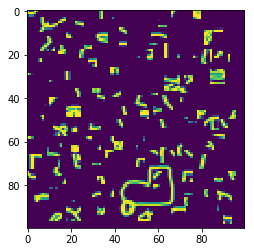

In [32]:
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# load training images with numpy
images_train = np.load('train_images.npy', encoding='latin1')
print("Training image shape: ",images_train.shape)

# load labels with numpy
train_labels = np.genfromtxt('train_labels.csv', names=True, delimiter=',', dtype=[('Id', 'i8'), ('Category', 'S5')])
print("Training labels shape: ", train_labels.shape)

#Reshaping image to 100x100
image_train1 = (images_train[32][1]).reshape(100,100)
plt.imshow(image_train1)


In [56]:
#Printing label
number_of_classes = np.unique(train_labels['Category']).size
print("Number of classes: ", number_of_classes)
# Mapping string name to class number:

class_names = np.unique(train_labels['Category'])
print(class_names)

def get_class_nb(lable):
    return np.argwhere(class_names == lable).item()

def get_class_name(indx):
    return class_names[indx]

class_nb_example = get_class_nb(train_labels[0]['Category'])
print()
print("Example: ", train_labels[0]['Category'], " is class number ", class_nb_example)
print("Example reverse:", class_nb_example, " is ", get_class_name(class_nb_example))


Number of classes:  31
[b'apple' b'empty' b'moust' b'mouth' b'mug' b'nail' b'nose' b'octag'
 b'paint' b'panda' b'parro' b'peanu' b'pear' b'penci' b'pengu' b'pillo'
 b'pinea' b'pool' b'rabbi' b'rhino' b'rifle' b'rolle' b'sailb' b'scorp'
 b'screw' b'shove' b'sink' b'skate' b'skull' b'spoon' b'squig']

Example:  b'shove'  is class number  25
Example reverse: 25  is  b'shove'


In [ ]:
# Replace string labels with class numbers
# To map it back to the lable, use get_class_name




Image shape:  (10000, 2)
Image ID:  0


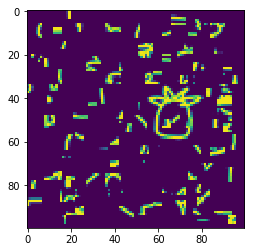

In [44]:
#Load test images with numpy
images_test = np.load('test_images.npy', encoding='latin1')
print("Image shape: ", images_test.shape)

# Reshape test images
print("Image ID: ", images_test[0][0])
image_test1 = (images_test[0][1]).reshape(100,100)
plt.imshow(image_test1)

In [5]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


In [17]:
# Converting numpy array to pytorch
train_tensor = torch.stack([torch.Tensor(i) for i in images_train])
tensor_y = torch.stack([torch.Tensor(i) for i in train_labels])


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: double, float, float16, int64, int32, and uint8.